In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df=pd.read_csv('data_v1/df_final.csv')

In [18]:
latest_stops_df = df.loc[df.groupby(["raceId", "driverId", "constructorId"])["stop"].idxmax()]

In [19]:
latest_stops_df.to_csv('data_v1/latest_stops_df.csv', index=False)

In [20]:
latest_stops_df.rename(columns={'stop':'numStops'}, inplace=True)


In [21]:
latest_stops_df.drop(['lap','milliseconds'],axis=1,inplace=True)

In [28]:
#position=1 as 1 else 0
latest_stops_df['positionOrder'] = latest_stops_df['positionOrder'].apply(lambda x: 1 if x==1 else 0)

In [30]:
latest_stops_df['positionOrder'].sum()

273

In [33]:
latest_stops_df.drop(['raceId'],axis=1,inplace=True)

In [34]:
latest_stops_df.to_csv('data_v1/latest_stops_df1.csv', index=False)

In [36]:
latest_stops_df.head()

,driverId,constructorId,grid,positionOrder,laps,circuitId,numStops
3,1,1,2,0,58,1,2
28,2,4,18,0,57,1,2
38,3,131,7,0,22,1,1
8,4,6,5,0,58,1,3
39,5,205,19,0,19,1,1


In [83]:
latest_stops_train = latest_stops_df.drop(['positionOrder'],axis=1)
latest_stops_target = latest_stops_df['positionOrder']

In [89]:
from sklearn.model_selection import train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(latest_stops_train, latest_stops_target, test_size=0.2, random_state=42)   

In [37]:
#one hot encoding of drverID, constructorId, circuitId
df_training = pd.get_dummies(latest_stops_df, columns=['driverId','constructorId','circuitId'])

In [38]:
df_training.to_csv('data_v1/df_training.csv', index=False)

In [40]:
from sklearn.model_selection import train_test_split
X = df_training.drop(['positionOrder'], axis=1)
Y = df_training['positionOrder']

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [45]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(4276, 135)
(1070, 135)
(4276,)
(1070,)


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

logreg = LogisticRegression(class_weight='balanced',max_iter=1000)
logreg.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [107]:
#save the model
import joblib
joblib.dump(logreg, 'lr_model.pkl')

['lr_model.pkl']

In [52]:
y_pred_train=logreg.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      4059
           1       0.28      0.95      0.44       217

    accuracy                           0.88      4276
   macro avg       0.64      0.91      0.68      4276
weighted avg       0.96      0.88      0.91      4276



In [53]:
y_pred=logreg.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1014
           1       0.27      0.93      0.42        56

    accuracy                           0.87      1070
   macro avg       0.63      0.90      0.67      1070
weighted avg       0.96      0.87      0.90      1070



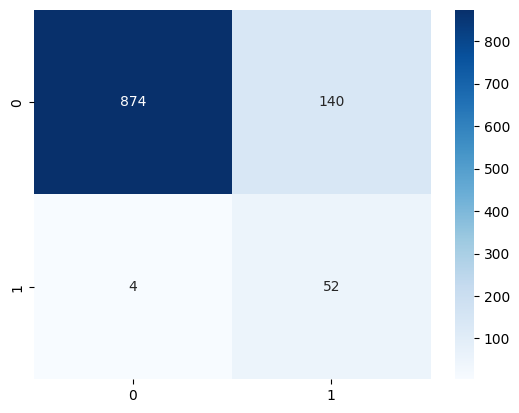

In [56]:
cm=confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [108]:
#K fold and plot the curves for all folds
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_val_score(logreg, X_train, Y_train, cv=kfold, scoring='f1')
print(cv_results)


[0.40659341 0.42156863 0.41530055 0.39106145 0.42553191]


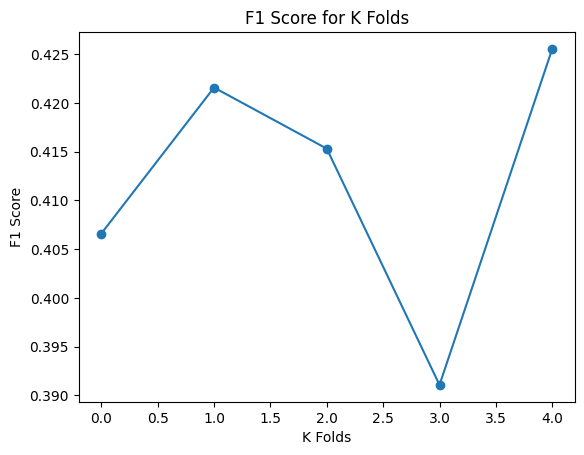

In [113]:
plt.plot(cv_results, marker='o')
plt.xlabel('K Folds')
plt.ylabel('F1 Score')
plt.title('F1 Score for K Folds')
plt.show()

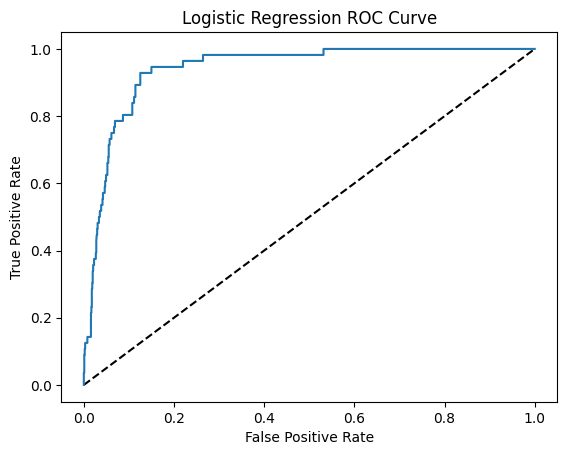

In [111]:
#plot the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()


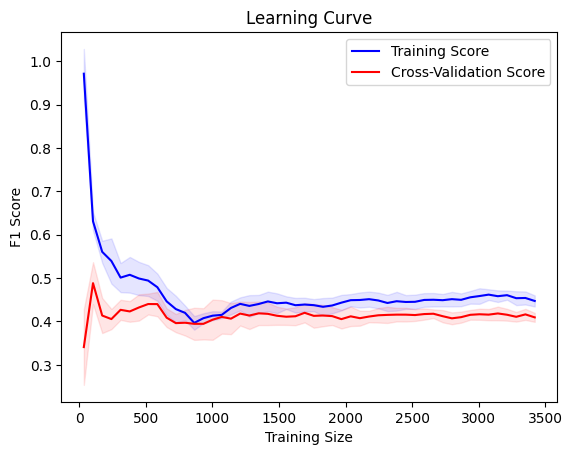

In [114]:
#plot bias variance tradeoff
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(logreg, X_train, Y_train, cv=kfold, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='red')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, color='red', alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [103]:
#xg
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [104]:
y_pred_train=xgb.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4059
           1       0.88      0.75      0.81       217

    accuracy                           0.98      4276
   macro avg       0.93      0.87      0.90      4276
weighted avg       0.98      0.98      0.98      4276



              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1014
           1       0.60      0.43      0.50        56

    accuracy                           0.96      1070
   macro avg       0.78      0.71      0.74      1070
weighted avg       0.95      0.96      0.95      1070



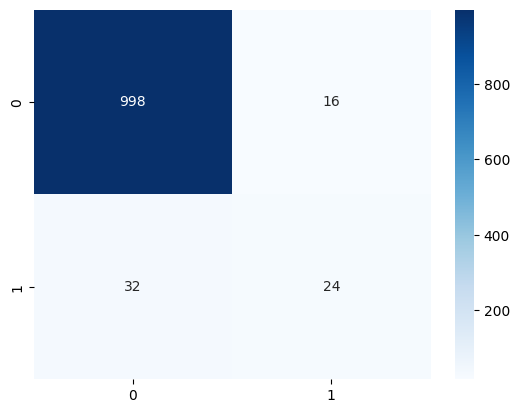

In [105]:
y_pred=xgb.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [57]:
# smote
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)


In [58]:
lr=LogisticRegression(class_weight='balanced',max_iter=1000)
lr.fit(X_train_smote, Y_train_smote)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [106]:
#save model
import joblib
joblib.dump(lr, 'lr_model.pkl')

['lr_model.pkl']

In [59]:
y_pred_train=lr.predict(X_train_smote)

print(classification_report(Y_train_smote, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4059
           1       0.96      0.97      0.97      4059

    accuracy                           0.97      8118
   macro avg       0.97      0.97      0.97      8118
weighted avg       0.97      0.97      0.97      8118



[0.95151515 0.96086695 0.96526946 0.96263458 0.9654336 ]


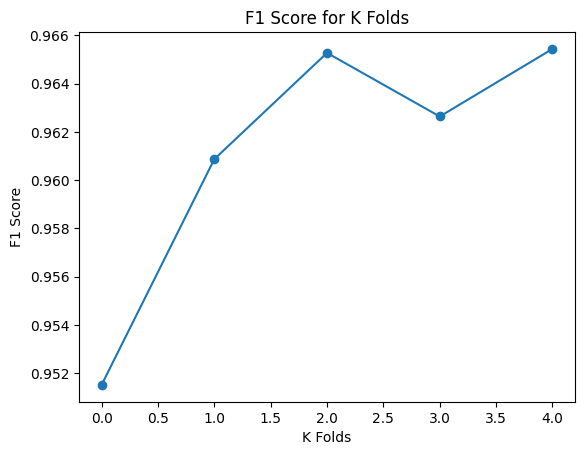

In [115]:
# K fold and plot the curves for all folds
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
cv_results = cross_val_score(lr, X_train_smote, Y_train_smote, cv=kfold, scoring='f1')
print(cv_results)

plt.plot(cv_results, marker='o')
plt.xlabel('K Folds')
plt.ylabel('F1 Score')
plt.title('F1 Score for K Folds')
plt.show()

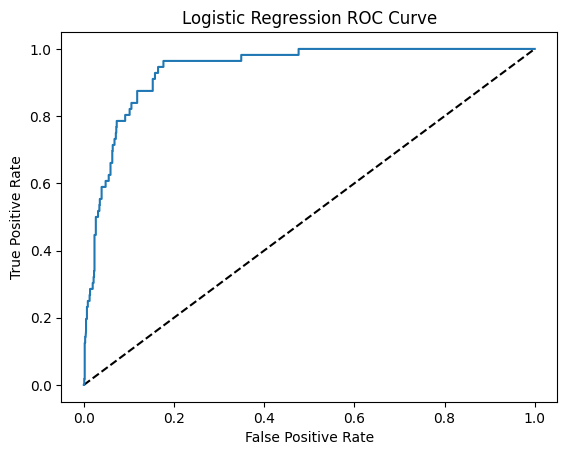

In [116]:
# plot the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_prob = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()


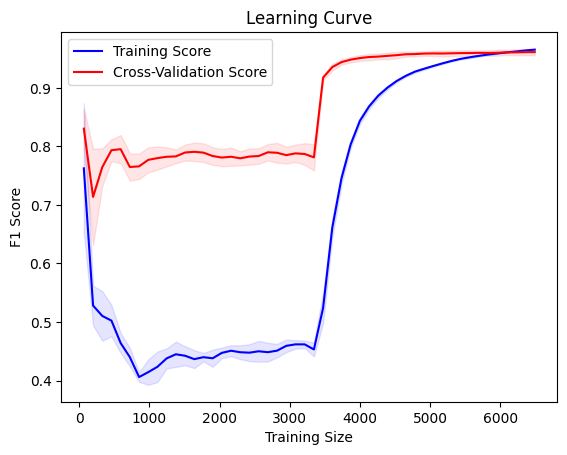

In [117]:
# plot bias variance tradeoff
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(lr, X_train_smote, Y_train_smote, cv=kfold, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)
plt.title('Learning Curve')

plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [119]:
y_pred=lr.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1014
           1       0.37      0.62      0.46        56

    accuracy                           0.92      1070
   macro avg       0.67      0.78      0.71      1070
weighted avg       0.95      0.92      0.93      1070



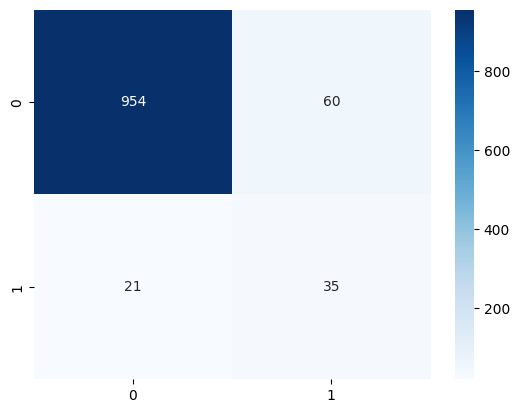

In [120]:
cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [ ]:
#K fold
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, X_train, Y_train, cv=5, scoring='f1')

In [66]:
#xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_smote, Y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:

y_pred_train=xgb.predict(X_train_smote)

print(classification_report(Y_train_smote, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4059
           1       0.98      0.99      0.99      4059

    accuracy                           0.99      8118
   macro avg       0.99      0.99      0.99      8118
weighted avg       0.99      0.99      0.99      8118



In [68]:
y_pred=xgb.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1014
           1       0.47      0.59      0.52        56

    accuracy                           0.94      1070
   macro avg       0.72      0.78      0.75      1070
weighted avg       0.95      0.94      0.95      1070



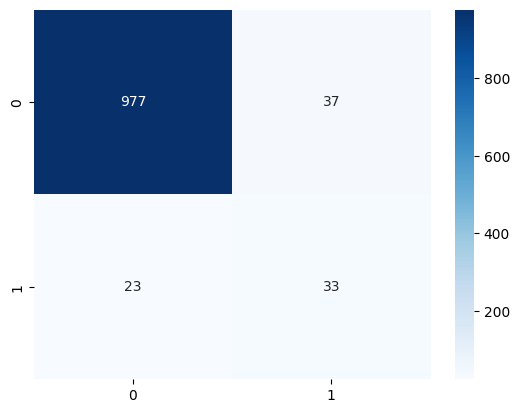

In [69]:
cm=confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [77]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
rf.fit(X_train, Y_train)

y_pred_train=rf.predict(X_train)

print(classification_report(Y_train, y_pred_train))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4059
           1       0.91      1.00      0.95       217

    accuracy                           0.99      4276
   macro avg       0.95      1.00      0.97      4276
weighted avg       1.00      0.99      0.99      4276



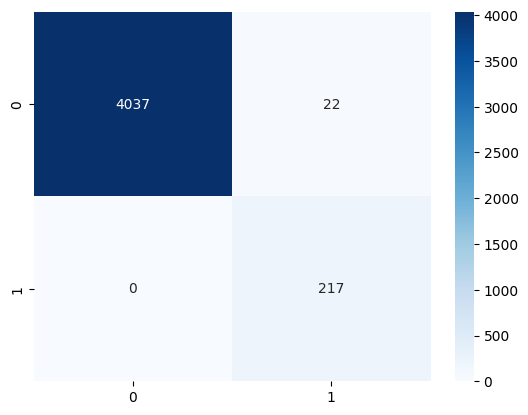

In [78]:
cm=confusion_matrix(Y_train, y_pred_train)
sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1014
           1       0.50      0.36      0.42        56

    accuracy                           0.95      1070
   macro avg       0.73      0.67      0.69      1070
weighted avg       0.94      0.95      0.94      1070



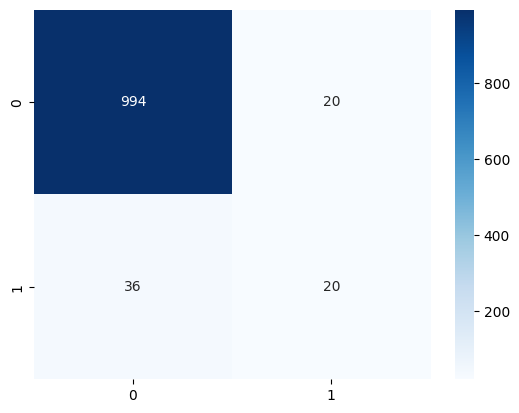

In [79]:
y_pred=rf.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [80]:

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)
mlp.fit(X_train, Y_train)



MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)

In [81]:
y_pred_train=mlp.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4059
           1       0.83      0.71      0.77       217

    accuracy                           0.98      4276
   macro avg       0.91      0.85      0.88      4276
weighted avg       0.98      0.98      0.98      4276



              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1014
           1       0.50      0.46      0.48        56

    accuracy                           0.95      1070
   macro avg       0.74      0.72      0.73      1070
weighted avg       0.95      0.95      0.95      1070



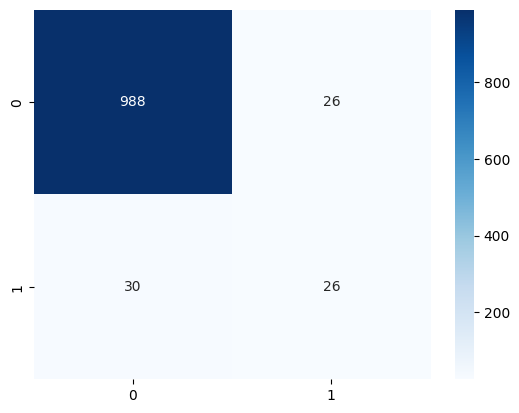

In [82]:
y_pred=mlp.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [84]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)


In [86]:
rf.fit(x1_train, y1_train)

RandomForestClassifier(class_weight='balanced')

In [87]:
y_pred_train=rf.predict(x1_train)

print(classification_report(y1_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4059
           1       0.91      1.00      0.95       217

    accuracy                           0.99      4276
   macro avg       0.95      1.00      0.97      4276
weighted avg       1.00      0.99      0.99      4276



              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1014
           1       0.50      0.34      0.40        56

    accuracy                           0.95      1070
   macro avg       0.73      0.66      0.69      1070
weighted avg       0.94      0.95      0.94      1070



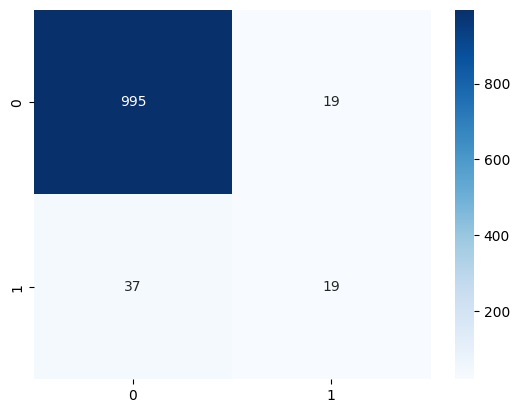

In [88]:
y_pred=rf.predict(x1_test)

print(classification_report(y1_test, y_pred))

cm=confusion_matrix(y1_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [92]:
#svm 
from sklearn.svm import SVC
svc = SVC(class_weight='balanced', kernel='linear')
svc.fit(X_train, Y_train)



SVC(class_weight='balanced', kernel='linear')

In [93]:
y_pred_train=svc.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      4059
           1       0.26      0.96      0.41       217

    accuracy                           0.86      4276
   macro avg       0.63      0.91      0.67      4276
weighted avg       0.96      0.86      0.90      4276



              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1014
           1       0.25      0.95      0.40        56

    accuracy                           0.85      1070
   macro avg       0.63      0.90      0.66      1070
weighted avg       0.96      0.85      0.89      1070



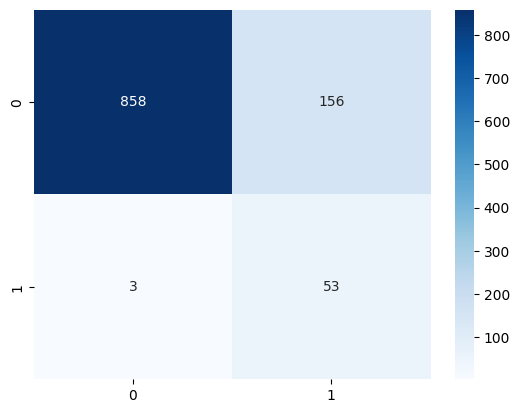

In [94]:
y_pred=svc.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [95]:
svc1=SVC(class_weight='balanced', kernel='rbf')
svc1.fit(X_train, Y_train)

SVC(class_weight='balanced')

In [96]:
y_pred_train=svc1.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88      4059
           1       0.19      0.93      0.32       217

    accuracy                           0.80      4276
   macro avg       0.59      0.86      0.60      4276
weighted avg       0.95      0.80      0.85      4276



              precision    recall  f1-score   support

           0       0.99      0.78      0.88      1014
           1       0.19      0.93      0.32        56

    accuracy                           0.79      1070
   macro avg       0.59      0.86      0.60      1070
weighted avg       0.95      0.79      0.85      1070



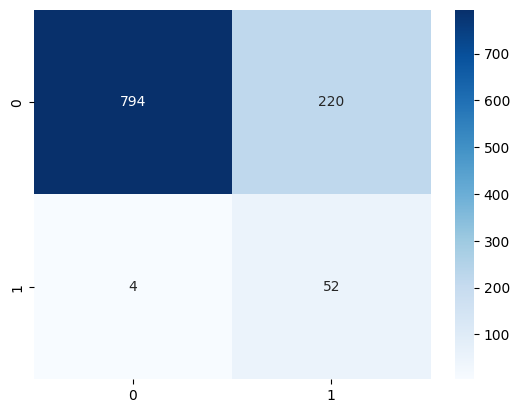

In [97]:
y_pred=svc1.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [100]:
#passive agressive classifier
from sklearn.linear_model import PassiveAggressiveClassifier

pac = PassiveAggressiveClassifier(max_iter=1000,class_weight='balanced')
pac.fit(X_train, Y_train)



PassiveAggressiveClassifier(class_weight='balanced')

In [101]:


y_pred_train=pac.predict(X_train)

print(classification_report(Y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4059
           1       0.45      0.55      0.49       217

    accuracy                           0.94      4276
   macro avg       0.71      0.76      0.73      4276
weighted avg       0.95      0.94      0.95      4276



              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1014
           1       0.47      0.61      0.53        56

    accuracy                           0.94      1070
   macro avg       0.73      0.78      0.75      1070
weighted avg       0.95      0.94      0.95      1070



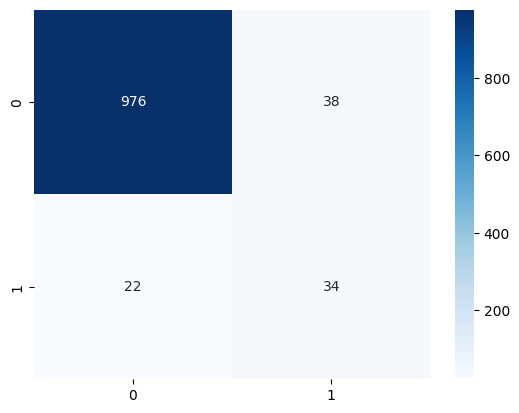

In [102]:
y_pred=pac.predict(X_test)

print(classification_report(Y_test, y_pred))

cm=confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues',fmt='d');

In [ ]:
#load back the model

